In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local imports
!pip install zat
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix

# Printing versions
print('zat: {:s}'.format(zat.__version__))
print('Numpy: {:s}'.format(np.__version__))


zat: 0.4.3
Numpy: 1.19.5


## Quickly go from Zeek log to Pandas DataFrame

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
zeek_df = log_to_df.create_dataframe('/content/drive/MyDrive/Universita/Magistrale/Tesi/ZeekML/Logs/s7comm.log')

# Print out the head of the dataframe

zeek_df.tail()


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,rosctr,parameter,item_count,data_info
ts,,,,,,,,,
2021-02-05 02:17:32.414690018,Cp7gqA4cyzIhKB1eke,167.248.133.39,33920,192.168.1.4,102,Acknowledge Data,"class=No error,code=0,type=Setup Communication",<NA>,(empty)
2021-02-05 02:17:32.565212011,Cp7gqA4cyzIhKB1eke,167.248.133.39,33920,192.168.1.4,102,User Data,"mode=Request,group=CPU Functions,sub=Read SZL",<NA>,Octet String id=0x0011 index=0001
2021-02-05 02:17:32.565466881,Cp7gqA4cyzIhKB1eke,167.248.133.39,33920,192.168.1.4,102,User Data,"mode=Response,group=CPU Functions,sub=Read SZL...",<NA>,Octet String id=0x0011 index=0000
2021-02-05 02:17:32.717113972,Cp7gqA4cyzIhKB1eke,167.248.133.39,33920,192.168.1.4,102,User Data,"mode=Request,group=CPU Functions,sub=Read SZL",<NA>,Octet String id=0x001c index=0001
2021-02-05 02:17:32.717433929,Cp7gqA4cyzIhKB1eke,167.248.133.39,33920,192.168.1.4,102,User Data,"mode=Response,group=CPU Functions,sub=Read SZL...",<NA>,Octet String id=0x001c index=0000



Plottiamo il numero di ocorrenze per tipo di funzione invocata

https://github.com/amzn/zeek-plugin-s7comm/blob/master/scripts/consts.zeek

Sezione const cotp_types

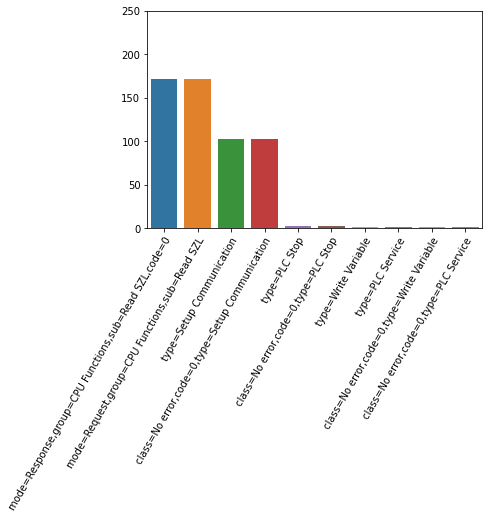

In [5]:
#print(zeek_df['pdu_type'].value_counts())
#zeek_df['pdu_type'].value_counts().plot.bar()

import seaborn
!pip install tikzplotlib
import tikzplotlib
#plt.hist(zeek_df['pdu_type'], log=True) 

s7_fc_plot= seaborn.countplot(data=zeek_df, x='parameter', order=zeek_df.parameter.value_counts().index)
#s7_fc_plot.set(yscale="log")

s7_fc_plot.set_xticklabels(s7_fc_plot.get_xticklabels(),rotation=60,ha="right",rotation_mode='anchor')
plt.ylim(0, 250)

plt.xlabel("", size=12)
plt.ylabel("", size=12)

tikzplotlib.save("test.tex")


plt.savefig("s7comm.pdf", bbox_inches='tight')
plt.show()

#S7comm codes 

In [6]:
print(zeek_df[['parameter','data_info']].value_counts())

parameter                                              data_info                        
type=Setup Communication                               (empty)                              102
class=No error,code=0,type=Setup Communication         (empty)                              102
mode=Response,group=CPU Functions,sub=Read SZL,code=0  Octet String id=0x001c index=0000     84
                                                       Octet String id=0x0011 index=0000     84
mode=Request,group=CPU Functions,sub=Read SZL          Octet String id=0x001c index=0001     80
                                                       Octet String id=0x0011 index=0001     80
                                                       Octet String id=0x001c index=0000      4
                                                       Octet String id=0x0011 index=0000      4
mode=Response,group=CPU Functions,sub=Read SZL,code=0  Octet String id=0x0232 index=0004      3
mode=Request,group=CPU Functions,sub=Read SZL  

## Looking for Country


Deleting rows that include local IP address



In [7]:
zeek_df = zeek_df[~zeek_df['id.orig_h'].isin(['192.168.1.7'])]

27.122.12.232      36
178.73.215.171     30
74.120.14.53       24
89.248.174.3       18
162.142.125.38     18
                   ..
192.241.215.169     6
192.241.221.186     6
27.122.12.247       4
178.32.197.83       2
192.168.1.7         0
Name: id.orig_h, Length: 66, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


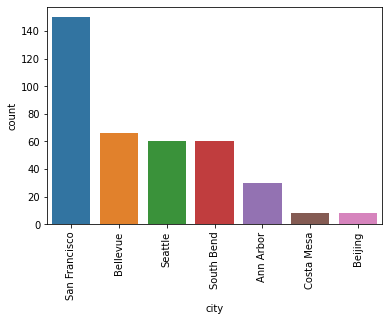

In [8]:
!pip install maxminddb-geolite2
!pip install pygeoip  
!pip install tikzplotlib
import tikzplotlib

import seaborn
import pandas as pd
from geolite2 import geolite2

def get_city(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['city']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

geo = geolite2.reader()




# get unique IPs
unique_ips = zeek_df['id.orig_h'].unique()
# make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)
# map IP --> city
print(zeek_df['id.orig_h'].value_counts())

zeek_df['city'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_city))

#print(zeek_df['city'])


#plot logarithmic
zeek_df['city'].value_counts().plot.bar()


actors_plot = seaborn.countplot(data=zeek_df, x='city', order=zeek_df.city.value_counts().index)
plt.xticks(rotation=90)
plt.show()
#geolite2.close()



##Looking for DNS (vedi distro ip Zanero)


In [9]:
!pip install dnspython
from dns import resolver,reversename
import dns.exception

def get_dns(ip):
    try:
        return str(resolver.query(reversename.from_address(ip), 'PTR')[0])
    except dns.exception.DNSException:
        return pd.np.nan

unique_ips = zeek_df['id.orig_h'].unique()
# make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)
# map IP --> country
print(zeek_df['id.orig_h'])

zeek_df['dns'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_dns))

print(zeek_df['dns'].value_counts())


#zeek_df['dns'].value_counts().plot.bar()




ts
2021-01-04 19:24:14.534172058      71.6.167.124
2021-01-04 19:24:14.534384011      71.6.167.124
2021-01-04 19:24:15.097041130      71.6.167.124
2021-01-04 19:24:15.097278833      71.6.167.124
2021-01-04 19:24:15.283002853      71.6.167.124
                                      ...      
2021-02-05 02:17:32.414690018    167.248.133.39
2021-02-05 02:17:32.565212011    167.248.133.39
2021-02-05 02:17:32.565466881    167.248.133.39
2021-02-05 02:17:32.717113972    167.248.133.39
2021-02-05 02:17:32.717433929    167.248.133.39
Name: id.orig_h, Length: 550, dtype: category
Categories (66, object): ['139.219.13.13', '162.142.125.37', '162.142.125.38', '162.142.125.39', ...,
                          '89.248.167.131', '89.248.174.3', '89.47.62.108', '93.174.95.106']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: please use dns.resolver.resolve() instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


scanner-07.ch1.censys-scanner.com.    42
scanner-09.ch1.censys-scanner.com.    36
scanner-04.ch1.censys-scanner.com.    36
scanner-08.ch1.censys-scanner.com.    30
178-73-215-171-static.glesys.net.     30
scanner-05.ch1.censys-scanner.com.    24
scanner-06.ch1.censys-scanner.com.    18
security.criminalip.com.              18
worker-10.sfj.censys-scanner.com.     12
census8.shodan.io.                     8
ubuntu14167124.aspadmin.net.           8
hat.census.shodan.io.                  8
pirate.census.shodan.io.               8
battery.census.shodan.io.              8
red.census.shodan.io.                  8
einstein.census.shodan.io.             8
mason.census.shodan.io.                8
dojo.census.shodan.io.                 8
zg-0830d-168.stretchoid.com.           6
zg-0830d-11.stretchoid.com.            6
worker-05.sfj.censys-scanner.com.      6
zg-0830d-92.stretchoid.com.            6
zg-0830d-73.stretchoid.com.            6
ns3.rfc0.net.                          6
worker-06.sfj.ce

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##Number of connections per actor (unique). (remove 

 A handful of actors generates the majority of the ICS traffic.

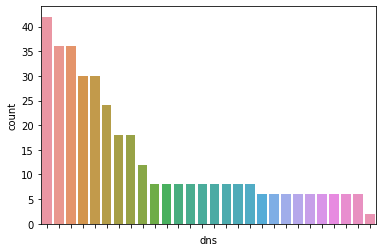

In [10]:

actors_plot = seaborn.countplot(data=zeek_df, x='dns', order=zeek_df.dns.value_counts().index)
actors_plot.set(xticklabels=[]) 
plt.show()

##Looking for ASN and Organization




In [11]:
!pip install geoip2

import geoip2.database

#Upload maxmind geoasn then put to drive

#Generic exception, no asnexception found


def get_asn(ip):
  try:
    with geoip2.database.Reader('/content/drive/MyDrive/Universita/Magistrale/Tesi/DBs/GeoLite2-ASN.mmdb') as reader:
      response = reader.asn(ip)
      #print(response.autonomous_system_number)
      #print(response.autonomous_system_organization)
      return response.autonomous_system_number
  except:
    return pd.np.nan


def get_org(ip):
  try:
    with geoip2.database.Reader('/content/drive/MyDrive/Universita/Magistrale/Tesi/DBs/GeoLite2-ASN.mmdb') as reader:
      response = reader.asn(ip)
      #print(response.autonomous_system_organization)
      return response.autonomous_system_organization
  except:
    return pd.np.nan

unique_ips = zeek_df['id.orig_h'].unique()
# make series out of it
unique_ips = pd.Series(unique_ips, index = unique_ips)


zeek_df['asn'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_asn))

zeek_df['org'] = zeek_df['id.orig_h'].map(unique_ips.apply(get_org))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##All s7comm Function Codes



In [12]:

zeek_df[['asn','org','dns','parameter','data_info']].value_counts().head(500).to_latex()
#zeek_df[['param','data_info']].value_counts().head(10).to_latex()

'\\begin{tabular}{lllllr}\n\\toprule\n         &                  &                              &                                                       &                                   &  0 \\\\\nasn & org & dns & parameter & data\\_info &    \\\\\n\\midrule\n398705.0 & CENSYS-ARIN-02 & scanner-07.ch1.censys-scanner.com. & mode=Response,group=CPU Functions,sub=Read SZL,code=0 & Octet String id=0x001c index=0000 &  7 \\\\\n         &                  &                              & class=No error,code=0,type=Setup Communication & (empty) &  7 \\\\\n         &                  &                              & mode=Request,group=CPU Functions,sub=Read SZL & Octet String id=0x0011 index=0001 &  7 \\\\\n         &                  &                              &                                                       & Octet String id=0x001c index=0001 &  7 \\\\\n         &                  &                              & mode=Response,group=CPU Functions,sub=Read SZL,code=0 & Octet St

Top 10 IP addresses per function code

##Check ASN Reputation

#Function Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

le.fit(zeek_df['parameter'])
ef=le.transform(zeek_df['parameter'])





zeek_df['ef']=ef

#Pandas ASN and encoded function
asn_ef = zeek_df[['id.orig_h','asn','org','ef','parameter']]

#asn_ef
#asn_ef= asn_ef.groupby(pd.Grouper(freq='60Min', base=30, label='right')).first()


#Pandas read csv dataframe rows from specific date and time range
asn_ef.index = pd.to_datetime(asn_ef.index)
mask = (asn_ef.index > '2021-01-24 00:00:00') & (asn_ef.index <= '2021-01-24 23:59:59')
asn_ef = asn_ef.loc[mask]


# 0 = READ_DEVICE_IDENTIFICATION
# 1 = READ_HOLDING_REGISTERS
# 2 = READ_INPUT_REGISTERS_EXCEPTION
# 3 = REPORT_SLAVE_ID
# 4 = WRITE_MULTIPLE_REGISTERS
# 5 = WRITE_MULTIPLE_REGISTERS_EXCEPTION
# 6 = unknown-218


#Find pattern
#fc_list = asn_ef.groupby('asn')['ef'].apply(list).reset_index(name='sequence').resample('60Min')
#fc_list

fc_list = asn_ef.groupby('id.orig_h')['ef'].apply(list).reset_index(name='sequence')
#fc_list = asn_ef.groupby('asn')['func'].apply(list).reset_index(name='sequence')



#6 gen 2021	27.122.12.245	[2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# 15 gen 2021 185.104.184.99	[2, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
# 25 gen 2021 93.174.95.106	[3, 0, 6, 6, 6, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
# 30 gen 71.6.199.23	[3, 0, 6, 6, 6, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
# 5 feb 2021 71.6.146.185	[3, 0, 6, 6, 6, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
#asn_ef_interval = asn_ef.resample('60Min')
fc_list.to_csv('pattern.csv')
asn_ef.to_csv('encoded_func.csv')

fc_list.describe()

print(le.inverse_transform([8, 2, 4, 5, 9, 3]))

['type=Setup Communication'
 'class=No error,code=0,type=Setup Communication'
 'mode=Request,group=CPU Functions,sub=Read SZL'
 'mode=Response,group=CPU Functions,sub=Read SZL,code=0'
 'type=Write Variable' 'class=No error,code=0,type=Write Variable']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
